# Analisis sentimen ulasan aplikasi gopay - Royan Rosyad

In [1]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.9 MB/s eta 0:00:00


In [2]:
# Import library yang dibutuhkan
import os
import re
import string
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests
from io import StringIO

# Konfigurasi pandas untuk menonaktifkan peringatan chaining
pd.options.mode.chained_assignment = None

# Mengatur seed untuk reproduktibilitas
seed = 0
np.random.seed(seed)

# Import pustaka NLTK (Natural Language Toolkit)
import nltk
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks
nltk.download('punkt_tab')
nltk.download('stopwords')  # Mengunduh daftar kata-kata berhenti (stop words) dalam berbagai bahasa

# Import library pemrosesan teks
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Import library untuk pemrosesan bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Import library untuk visualisasi data
from wordcloud import WordCloud

# Import library untuk machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Import library untuk deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, SpatialDropout1D,
    Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D,
    Flatten, GRU, SimpleRNN
)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Dataset

In [3]:
df_gopay = pd.read_csv('/content/ulasan_aplikasi_gopay_40K(2).csv')
df_gopay.head(10)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,284233f5-9f8f-423b-9651-57727576c082,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sangat kecewa, top up belum masuk, di pemberit...",1,137,1.44.0,2025-04-03 03:29:29,"Hai Kak @Gelas picah, pastikan nomor tujuan su...",2025-04-04 04:51:32,1.44.0
1,fa4501ee-9495-43be-92ef-8a617e59b135,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,gimana sih bg jago? dikasi limit pinjaman 500 ...,1,6,1.44.0,2025-04-05 08:20:56,"Hai Kak Badri, mohon maaf atas kendala yang ka...",2025-04-05 09:39:20,1.44.0
2,3749de91-807e-4fb7-b47c-9368bcc24ce7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,merasa hampir kecewa dengan Gopay. knpa setela...,1,5,1.44.0,2025-04-04 03:00:50,"Hai Kak Jhohan, mohon maaf atas ketidaknyamana...",2025-04-04 15:09:17,1.44.0
3,23cd30e6-10c8-4aa6-a202-70a066606818,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"gimana ya menurut gw ni apk GG si, semalem keh...",5,109,1.44.0,2025-04-03 05:45:52,NaN,NaN,1.44.0
4,bb1127cd-0d25-411d-9350-cf186fd240e5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"saya kasih bintang satu aja,karena gopay sudah...",1,12,1.44.0,2025-04-03 02:40:09,"Hai Kak Ananda, mohon maaf atas ketidaknyamana...",2025-04-03 14:51:58,1.44.0
5,21c0dc89-28e2-4960-9cf5-9c90243b936a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kecewa banget. rekam jejak pembayaran pinjaman...,1,6,1.44.0,2025-04-03 23:19:04,"Hai Kak @Mystery Shopers, mohon maaf atas kend...",2025-04-04 14:21:39,1.44.0
6,5e295fec-8e3b-4084-bceb-9289f0c6e2b9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",1,356,1.44.0,2025-03-31 08:40:12,"Hai Kak Charis, pastikan nomor tujuan sudah be...",2025-03-31 09:25:18,1.44.0
7,684a8c50-325c-4c0e-b5fa-6f4c6da1fcfd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,please lah mau transfer aja lama banget selalu...,1,5,1.44.0,2025-04-03 17:56:22,"Hai Kak Josephina, sebelum transfer, pastikan ...",2025-04-04 12:39:01,1.44.0
8,36a9994c-98e5-4427-84a5-d23484698d3b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"saya top up gopay, walau nominal kecil tapi ti...",1,23,1.44.0,2025-04-02 15:43:33,"Hai Kak Fathul, mohon maaf atas ketidaknyamana...",2025-04-03 05:14:47,1.44.0
9,7bb49aa1-d6b1-473d-9d38-19810d38a691,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya membingunkan. Semua fiturnya harus...,2,274,1.40.1,2025-02-05 01:21:13,"Hai Kak Puji, mohon maaf atas ketidaknyamanann...",2025-02-05 03:01:18,1.40.1


In [4]:
# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = df_gopay.shape

print(jumlah_ulasan)
print(jumlah_kolom)

40000
11


In [5]:
df_gopay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              40000 non-null  object
 1   userName              40000 non-null  object
 2   userImage             40000 non-null  object
 3   content               40000 non-null  object
 4   score                 40000 non-null  int64 
 5   thumbsUpCount         40000 non-null  int64 
 6   reviewCreatedVersion  34254 non-null  object
 7   at                    40000 non-null  object
 8   replyContent          17135 non-null  object
 9   repliedAt             17135 non-null  object
 10  appVersion            34254 non-null  object
dtypes: int64(2), object(9)
memory usage: 3.4+ MB


Berdasarkan hasil df_gojek_reviews.info(), berikut adalah analisisnya:
- Dataset memiliki 40.000 entri dengan 11 kolom.
- Sebagian besar kolom memiliki data yang lengkap, kecuali: reviewCreatedVersion dan appVersion (hanya memiliki 34.254 nilai, artinya ada sekitar 5.746 data yang kosong).
- replyContent dan repliedAt (hanya 17135 data yang terisi, menunjukkan bahwa sebagian besar ulasan tidak mendapatkan balasan dari developer).
- Tipe data terdiri dari integer (score, thumbsUpCount) dan string untuk kolom lainnya.

Dalam analisis sentimen, tidak semua informasi yang tersedia dalam dataset memiliki relevansi. Ada beberapa kolom yang tidak memberikan kontribusi berarti terhadap analisis kita, seperti gambar pengguna (userImage), balasan dari developer (replyContent), versi aplikasi (reviewCreatedVersion dan appVersion), dan . Oleh karena itu, kita akan menghapusnya untuk membuat dataset lebih ringkas dan fokus.

In [6]:
df_gopay_cleaned = df_gopay.drop(columns=['userImage', 'replyContent', 'repliedAt', 'reviewCreatedVersion', 'appVersion'])

Dengan menghapus kolom yang tidak relevan, kita memastikan bahwa dataset kita lebih terfokus dan lebih mudah dikelola dalam analisis berikutnya.



In [7]:
# Show latest information about df_gopay
df_gopay_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       40000 non-null  object
 1   userName       40000 non-null  object
 2   content        40000 non-null  object
 3   score          40000 non-null  int64 
 4   thumbsUpCount  40000 non-null  int64 
 5   at             40000 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.8+ MB


Jika jumlah kolom berkurang sesuai dengan yang kita hapus, maka kita telah berhasil menyederhanakan dataset tanpa kehilangan informasi penting.

In [8]:
df_gopay_cleaned = df_gopay_cleaned.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
reviews_after_delete_duplicates, column_after_delete_duplicates = df_gopay_cleaned.shape


print("Jumlah ulasan setelah hapus data duplikat :", reviews_after_delete_duplicates)
print("Jumlah ulasan setelah hapus data duplikat :", column_after_delete_duplicates)

Jumlah ulasan setelah hapus data duplikat : 40000
Jumlah ulasan setelah hapus data duplikat : 6


Dengan langkah ini, kita memastikan bahwa dataset kita telah bersih dan siap digunakan untuk analisis sentimen.

### Data Preprocessing

Setelah cleaning dataset dengan menghapus kolom yang tidak relevan serta menghilangkan data duplikat, langkah berikutnya adalah melakukan pra-pemrosesan teks pada bagian ulasan (content). Tahapan ini bertujuan untuk membersihkan teks dari karakter yang tidak diperlukan, melakukan normalisasi, dan meningkatkan kualitas data agar siap digunakan dalam analisis lebih lanjut, seperti analisis sentimen atau pemodelan pembelajaran mesin.

In [9]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers


    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','rb','ny','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii",
                          "woy","deh", "cuy", "ges"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# unicode untuk emoticon, emoji, simbol dan lain - lain
def emojiRemove(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F700-\U0001F77F"
        "\U0001F780-\U0001F7FF"
        "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA00-\U0001FA6F"
        "\U0001FA70-\U0001FAFF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

Konversikan kumpulan kata slang atau istilah informal yang umum dipakai dalam percakapan sehari-hari ke dalam bentuk bahasa baku.

In [10]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin","app": "aplikasi", "apk": "aplikasi", "apknya": "aplikasi", "aplikasinya": "aplikasi", "good": "bagus", "g": "tidak", "gk": "tidak", "ok": "bagus", "oke": "bagus", "bagu": "bagus", "sukse": "sukses", "trus": "terus", "udh": "sudah", "pa": "pas", "ribet": "rumit", "pua": "puas", "terimakasih": "terima kasih", "go pay": "gopay", "go  pay": "gopay", "go   pay": "gopay", "e-money": "uang elektronik", "emoney": "uang elektronik", "e money": "uang elektronik", "pesen": "pesan", "x": "kali", "nunggu": "menunggu", "pay later": "paylater", "drivernya": "driver", "promonya": "promo", "mantap": "keren", "sya": "saya", "sdh": "sudah", "dr": "dari", "lbh": "lebih", "dlm": "dalam", "dg": "dengan", "sm": "sama", "order": "pesan", "orderan": "pesanan", "skrg": "sekarang", "bgettt": "banget", "ngebantu": "membantu", "org": "orang", "cb": "cashback", "cash back": "cashback", "disc": "diskon", "payment": "pembayaran", "pmbyrn": "pembayaran"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

Apply preprocessing text pada dataset

In [11]:
# Clean text dan simpen di kolom 'text_clean'
df_gopay_cleaned['text_clean'] = df_gopay_cleaned['content'].apply(cleaningText)

# Ubah huruf menjadi sama rata huruf kecil dan store di text_casefolding
df_gopay_cleaned['text_casefolding'] = df_gopay_cleaned['text_clean'].apply(casefoldingText)

# Ubah kata2 informal (slangwords) menjadi kata formal dan menyimpan di 'text_slangwords'
df_gopay_cleaned['text_slangwords'] = df_gopay_cleaned['text_casefolding'].apply(fix_slangwords)

# Hapus emoji disetiap kalimat dan menyimpannya di 'text_emoji_removes'
df_gopay_cleaned['text_emoji_removes'] = df_gopay_cleaned['text_slangwords'].apply(emojiRemove)

# Pecah teks menjadi sebuah token(kata2) dan simpan di 'text_tokenizing'
df_gopay_cleaned['text_tokenizing'] = df_gopay_cleaned['text_emoji_removes'].apply(tokenizingText)

# Hapus kata2 umum (stopword) dan simpan di 'text_stopwords'
df_gopay_cleaned['text_stopwords'] = df_gopay_cleaned['text_tokenizing'].apply(filteringText)

# Combine token2 menjadi sebuah kalimat dan simpan di 'teks_akhir'
df_gopay_cleaned['text_akhir'] = df_gopay_cleaned['text_stopwords'].apply(toSentence)

In [12]:
df_gopay_cleaned.head(20)

,reviewId,userName,content,score,thumbsUpCount,at,text_clean,text_casefolding,text_slangwords,text_emoji_removes,text_tokenizing,text_stopwords,text_akhir
0,284233f5-9f8f-423b-9651-57727576c082,Pengguna Google,"sangat kecewa, top up belum masuk, di pemberit...",1,137,2025-04-03 03:29:29,sangat kecewa top up belum masuk di pemberitah...,sangat kecewa top up belum masuk di pemberitah...,sangat kecewa top up belum masuk di pemberitah...,sangat kecewa top up belum masuk di pemberitah...,"[sangat, kecewa, top, up, belum, masuk, di, pe...","[kecewa, top, masuk, pemberitahuan, data, tran...",kecewa top masuk pemberitahuan data transaksi ...
1,fa4501ee-9495-43be-92ef-8a617e59b135,Pengguna Google,gimana sih bg jago? dikasi limit pinjaman 500 ...,1,6,2025-04-05 08:20:56,gimana sih bg jago dikasi limit pinjaman rb g...,gimana sih bg jago dikasi limit pinjaman rb g...,bagaimana sih abang jago dikasi limit pinjaman...,bagaimana sih abang jago dikasi limit pinjaman...,"[bagaimana, sih, abang, jago, dikasi, limit, p...","[abang, jago, dikasi, limit, pinjaman, giliran...",abang jago dikasi limit pinjaman giliran tarik...
2,3749de91-807e-4fb7-b47c-9368bcc24ce7,Pengguna Google,merasa hampir kecewa dengan Gopay. knpa setela...,1,5,2025-04-04 03:00:50,merasa hampir kecewa dengan Gopay knpa setelah...,merasa hampir kecewa dengan gopay knpa setelah...,merasa hampir kecewa dengan gopay kenapa setel...,merasa hampir kecewa dengan gopay kenapa setel...,"[merasa, hampir, kecewa, dengan, gopay, kenapa...","[kecewa, gopay, update, ada², kendala, mengisi...",kecewa gopay update ada² kendala mengisi saldo...
3,23cd30e6-10c8-4aa6-a202-70a066606818,Pengguna Google,"gimana ya menurut gw ni apk GG si, semalem keh...",5,109,2025-04-03 05:45:52,gimana ya menurut gw ni apk GG si semalem kehi...,gimana ya menurut gw ni apk gg si semalem kehi...,bagaimana iya menurut saya ini aplikasi gg si ...,bagaimana iya menurut saya ini aplikasi gg si ...,"[bagaimana, iya, menurut, saya, ini, aplikasi,...","[aplikasi, gg, si, semalem, kehilangan, saldo,...",aplikasi gg si semalem kehilangan saldo rbu ng...
4,bb1127cd-0d25-411d-9350-cf186fd240e5,Pengguna Google,"saya kasih bintang satu aja,karena gopay sudah...",1,12,2025-04-03 02:40:09,saya kasih bintang satu ajakarena gopay sudah ...,saya kasih bintang satu ajakarena gopay sudah ...,saya kasih bintang satu ajakarena gopay sudah ...,saya kasih bintang satu ajakarena gopay sudah ...,"[saya, kasih, bintang, satu, ajakarena, gopay,...","[kasih, bintang, ajakarena, gopay, kali, menge...",kasih bintang ajakarena gopay kali mengecewaka...
5,21c0dc89-28e2-4960-9cf5-9c90243b936a,Pengguna Google,kecewa banget. rekam jejak pembayaran pinjaman...,1,6,2025-04-03 23:19:04,kecewa banget rekam jejak pembayaran pinjaman ...,kecewa banget rekam jejak pembayaran pinjaman ...,kecewa banget rekam jejak pembayaran pinjaman ...,kecewa banget rekam jejak pembayaran pinjaman ...,"[kecewa, banget, rekam, jejak, pembayaran, pin...","[kecewa, banget, rekam, jejak, pembayaran, pin...",kecewa banget rekam jejak pembayaran pinjaman ...
6,5e295fec-8e3b-4084-bceb-9289f0c6e2b9,Pengguna Google,"kecewa, udah top up gak masuk masuk, nunggu 2 ...",1,356,2025-03-31 08:40:12,kecewa udah top up gak masuk masuk nunggu har...,kecewa udah top up gak masuk masuk nunggu har...,kecewa sudah top up gak masuk masuk menunggu h...,kecewa sudah top up gak masuk masuk menunggu h...,"[kecewa, sudah, top, up, gak, masuk, masuk, me...","[kecewa, top, masuk, masuk, menunggu, harikalo...",kecewa top masuk masuk menunggu harikalo infor...
7,684a8c50-325c-4c0e-b5fa-6f4c6da1fcfd,Pengguna Google,please lah mau transfer aja lama banget selalu...,1,5,2025-04-03 17:56:22,please lah mau transfer aja lama banget selalu...,please lah mau transfer aja lama banget selalu...,please lah mau transfer saja lama banget selal...,please lah mau transfer saja lama banget selal...,"[please, lah, mau, transfer, saja, lama, bange...","[please, transfer, banget, perbaikan, terusudh...",please transfer bang

## Pelabelan Data

In [13]:
def load_lexicon(url):
  lexicon = {}
  response = requests.get(url)

  # If request successfully
  if response.status_code == 200:
    # Read response text as a CSV file using a CSV reader with comma separator
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Add some positif or negative words
    lexicon = {row[0]: int(row[1]) for row in reader}
  else:
    print(f"Failed to fetch data from {url}")

  return lexicon

# URLs for lexicon data
lexicon_positive = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
lexicon_negative = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Load lexicon data
lexicon_positive = load_lexicon(lexicon_positive)
lexicon_negative = load_lexicon(lexicon_negative)

Menentukan fungsi untuk mengukur tingkat polaritas sentimen.

In [14]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
def sentiment_analysis_lexicon_indonesia(text):

    score = 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen


    # Menentukan polaritas berdasarkan skor
    if score > 0:
        polarity = 'positive'
    elif score < -1:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

Menghitung hasil polaritas data

In [15]:
results = df_gopay_cleaned['text_stopwords'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))

df_gopay_cleaned['polarity_score'] = results[0]
df_gopay_cleaned['polarity'] = results[1]

print(df_gopay_cleaned['polarity'].value_counts())

polarity
positive    16995
negative    16653
neutral      6352
Name: count, dtype: int64


In [16]:
netral_reviews = df_gopay_cleaned[df_gopay_cleaned['polarity'] == 'neutral']
netral_reviews.tail(5)

,reviewId,userName,content,score,thumbsUpCount,at,text_clean,text_casefolding,text_slangwords,text_emoji_removes,text_tokenizing,text_stopwords,text_akhir,polarity_score,polarity
39978,d70582e5-e4e2-415d-826a-c929db33bee1,Pengguna Google,"Sy kecewa,masak mu topup ke dana,g bs msh dipe...",1,0,2024-10-21 19:12:59,Sy kecewamasak mu topup ke danag bs msh diperb...,sy kecewamasak mu topup ke danag bs msh diperb...,saya kecewamasak mu topup ke danag bisa masih ...,saya kecewamasak mu topup ke danag bisa masih ...,"[saya, kecewamasak, mu, topup, ke, danag, bisa...","[kecewamasak, mu, topup, danag, diperbaiki, kt...",kecewamasak mu topup danag diperbaiki ktxapada...,0,neutral
39985,db21e741-c188-4e44-a55e-20543f0cf069,Pengguna Google,"sudah ganti pin,tetap ga bisa melakukan transfer",2,0,2024-10-09 19:50:09,sudah ganti pintetap ga bisa melakukan transfer,sudah ganti pintetap ga bisa melakukan transfer,sudah ganti pintetap ga bisa melakukan transfer,sudah ganti pintetap ga bisa melakukan transfer,"[sudah, ganti, pintetap, ga, bisa, melakukan, ...","[ganti, pintetap, transfer]",ganti pintetap transfer,0,neutral
39986,379e638c-34b6-4548-9c50-b022dd1d77a5,Pengguna Google,Parah saldo maen sedot aja tanpa konfirmasi,1,0,2024-10-23 14:54:11,Parah saldo maen sedot aja tanpa konfirmasi,parah saldo maen sedot aja tanpa konfirmasi,parah saldo main sedot saja tanpa konfirmasi,parah saldo main sedot saja tanpa konfirmasi,"[parah, saldo, main, sedot, saja, tanpa, konfi...","[parah, saldo, main, sedot, konfirmasi]",parah saldo main sedot konfirmasi,0,neutral
39988,0569e620-ae80-42c8-a4ca-2cc986432f70,Pengguna Google,"menyenangkan karena dimudahkan,, good job gopa...",5,0,2024-10-15 06:54:19,menyenangkan karena dimudahkan good job gopay ...,menyenangkan karena dimudahkan good job gopay ...,menyenangkan karena dimudahkan bagus job gopay...,menyenangkan karena dimudahkan bagus job gopay...,"[menyenangkan, karena, dimudahkan, bagus, job,...","[menyenangkan, dimudahkan, bagus, job, gopay, ...",menyenangkan dimudahkan bagus job gopay tengkiyu,-1,neutral
39990,faf30e99-a35b-4a84-b9a5-93473c767b0f,Pengguna Google,"saya tidak bisa masuk,terjadi keselahan teknis",3,0,2024-10-17 06:08:29,saya tidak bisa masukterjadi keselahan teknis,saya tidak bisa masukterjadi keselahan teknis,saya tidak bisa masukterjadi keselahan teknis,saya tidak bisa masukterjadi keselahan teknis,"[saya, tidak, bisa, masukterjadi, keselahan, t...","[masukterjadi, keselahan, teknis]",masukterjadi keselahan teknis,0,neutral


## Data Understanding

In [17]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 5000 karakter.
pd.set_option('display.max_colwidth', 5000)

# Fungsi untuk memproses tweet berdasarkan polaritas
def process_tweets(df, sentiment):
    filtered_tweets = df[df['polarity'] == sentiment][['text_akhir', 'polarity_score', 'polarity', 'text_stopwords']]
    filtered_tweets = filtered_tweets.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
    filtered_tweets.index += 1
    return filtered_tweets

# Membuat DataFrame untuk setiap kategori sentimen
positive_tweets = process_tweets(df_gopay_cleaned, 'positive')
negative_tweets = process_tweets(df_gopay_cleaned, 'negative')
neutral_tweets = process_tweets(df_gopay_cleaned, 'neutral')

In [18]:
def generate_wordcloud(dataframe, title):
    """
    Fungsi untuk membuat dan menampilkan word cloud dari kolom 'text_stopword' dalam DataFrame.

    Parameters:
        dataframe (pd.DataFrame): DataFrame yang berisi teks yang telah dibersihkan.
        title (str): Judul untuk word cloud.
    """
    list_words = ' '.join([' '.join(tweet) for tweet in dataframe['text_stopwords']])

    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title, fontsize=18)
    ax.grid(False)
    ax.imshow(wordcloud)
    ax.axis('off')
    fig.tight_layout(pad=0)
    plt.show()

### Word cloud general

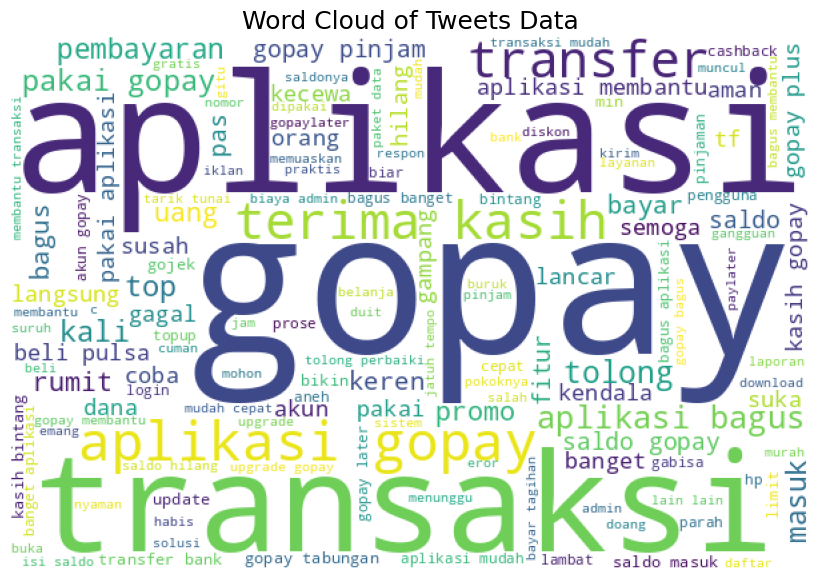

In [19]:
# Menampilkan word cloud untuk semua tweet, tweet negatif, dan tweet positif
generate_wordcloud(df_gopay_cleaned, 'Word Cloud of Tweets Data')

### Negative word cloud

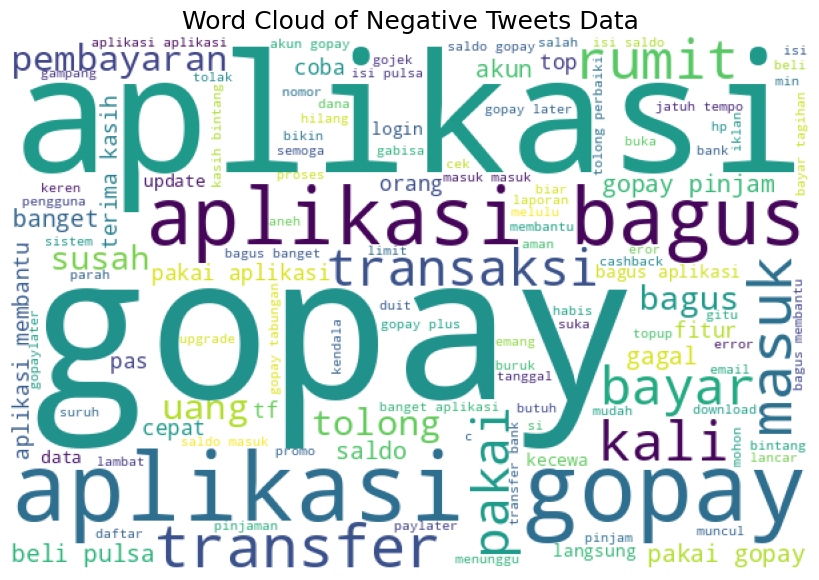

In [20]:
generate_wordcloud(negative_tweets, 'Word Cloud of Negative Tweets Data')

### Positive word cloud

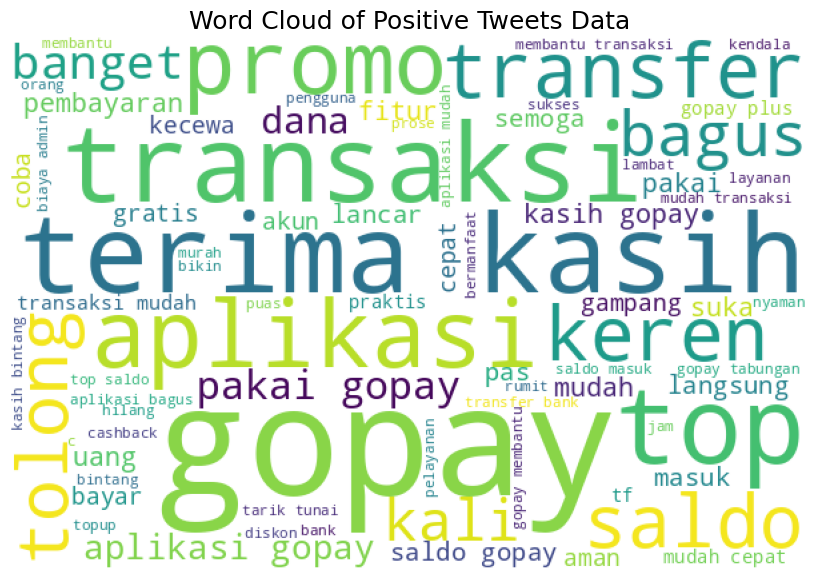

In [21]:
generate_wordcloud(positive_tweets, 'Word Cloud of Positive Tweets Data')

### Neutral word cloud

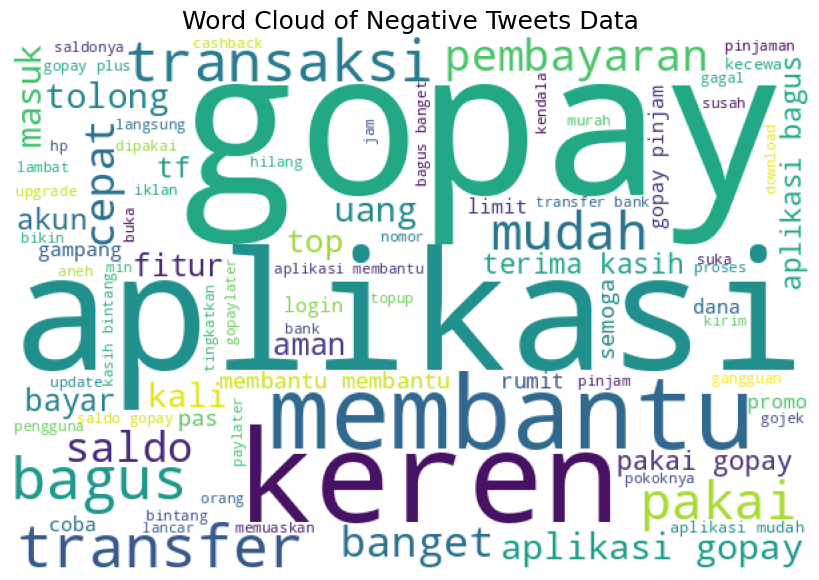

In [22]:
generate_wordcloud(neutral_tweets, 'Word Cloud of Negative Tweets Data')

## Visualisasi Dataset

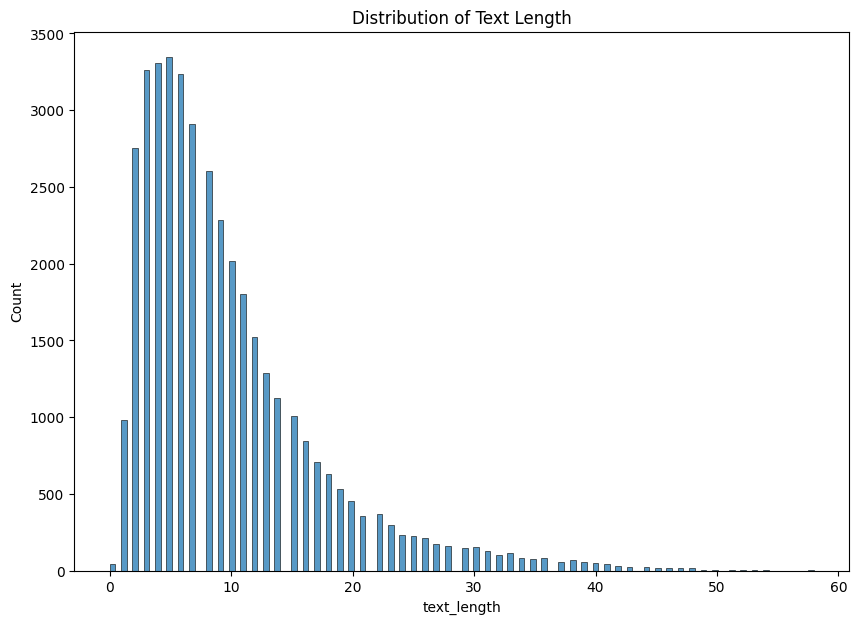

In [23]:
plt.figure(figsize=(10, 7))

# Visualisasi distribusi dari panjang text
df_gopay_cleaned['text_length'] = df_gopay_cleaned['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(df_gopay_cleaned['text_length'])
plt.title('Distribution of Text Length')
plt.show()

Visualisasi pie chart

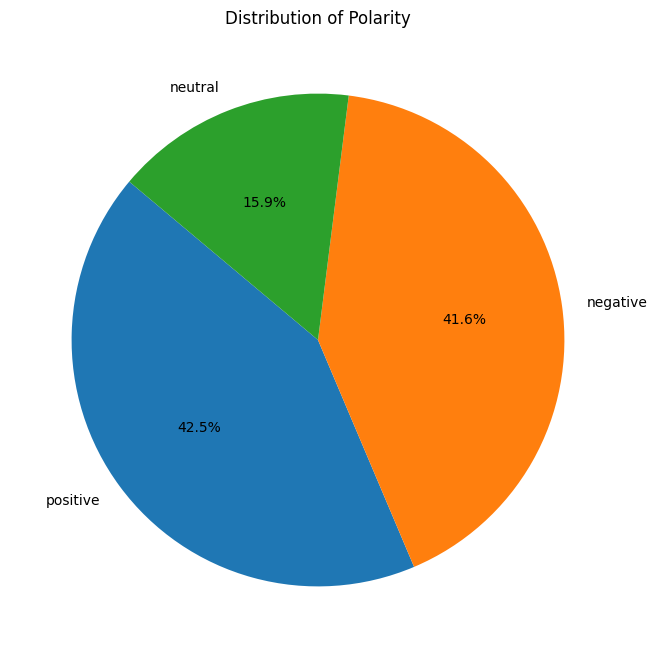

In [24]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = df_gopay_cleaned['polarity'].value_counts()

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Polarity')
plt.show()


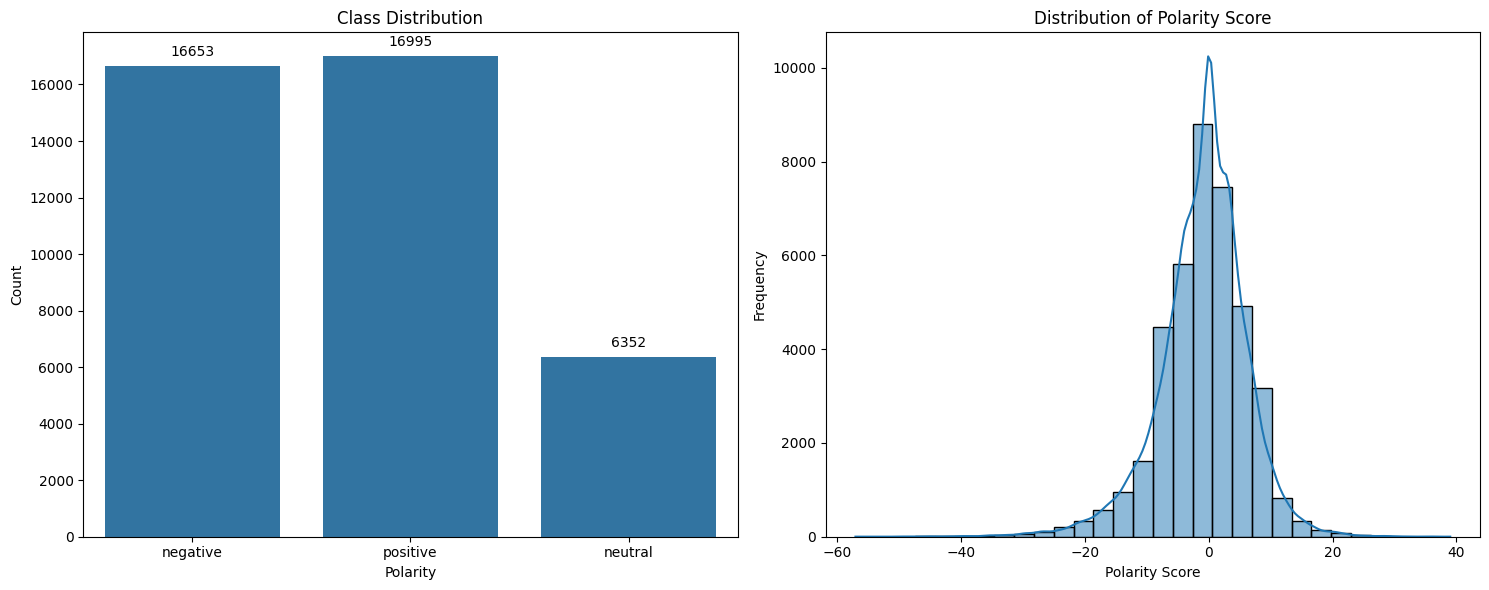

In [25]:
# Buat figure dan axis untuk menampilkan 2 plot sejajar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot distribusi kelas
sns.countplot(x='polarity', data=df_gopay_cleaned, ax=axes[0])
axes[0].set_title('Class Distribution')
axes[0].set_xlabel('Polarity')
axes[0].set_ylabel('Count')

# Menambahkan label jumlah data di atas tiap batang
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

# Plot distribusi polarity_score
sns.histplot(df_gopay_cleaned['polarity_score'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Polarity Score')
axes[1].set_xlabel('Polarity Score')
axes[1].set_ylabel('Frequency')

# Menampilkan plot
plt.tight_layout()
plt.show()

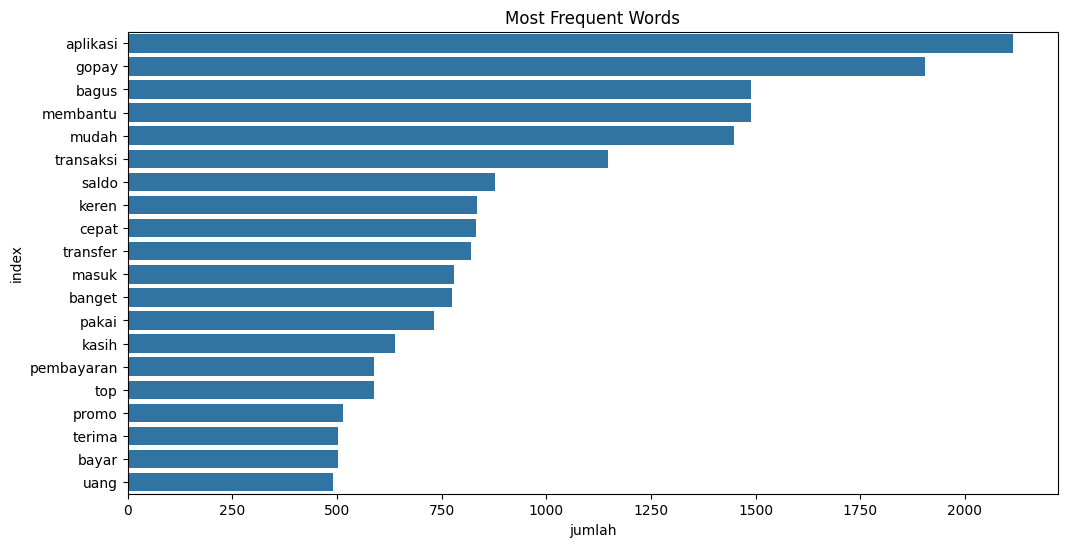

In [26]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_gopay_cleaned['text_akhir'])

# Konversi hasil ekstraksi fitur menjadi dataframe
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

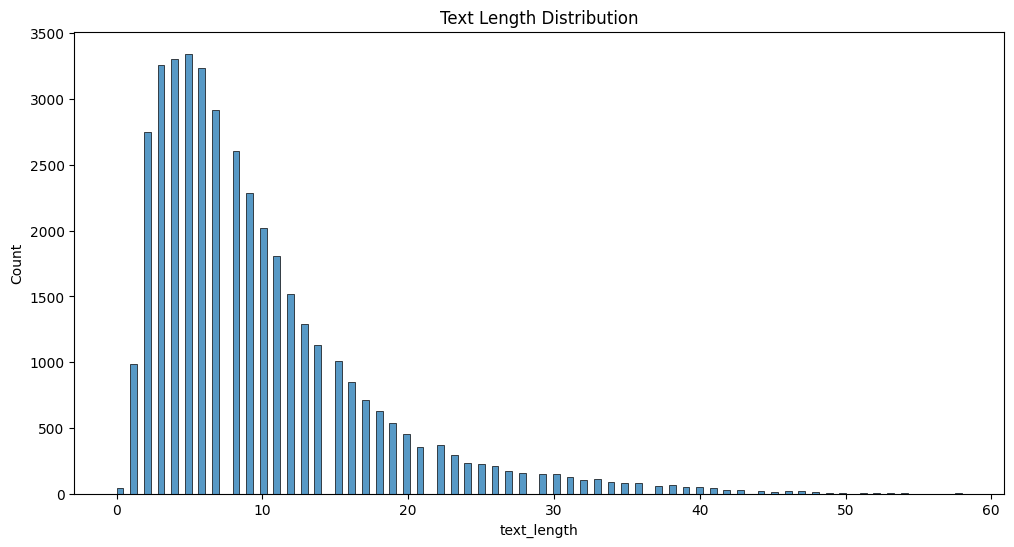

In [27]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize text length distribution
df_gopay_cleaned['text_length'] = df_gopay_cleaned['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(df_gopay_cleaned['text_length'])
plt.title('Text Length Distribution')
plt.show()

In [28]:
# Mengambil kolom text_akhir dan polarity
X = df_gopay_cleaned['text_akhir']
y = df_gopay_cleaned['polarity']

In [29]:
# Tokenisasi
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)

# Label encoding
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(y)
y = to_categorical(integer_encoded)

# Menentukan jumlah kelas
num_classes = y.shape[1]

In [30]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.92:
            print(f"\nVal accuracy sudah lebih dari 0.92, stop train pada epoch {epoch+1}")
            self.model.stop_training = True
early_stopping = CustomCallback()

## **Modelling**
### Model 1 - LSTM dengan 80/20 split**

In [31]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_LSTM, y_train_val, y_test_LSTM = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_train_val, y_train_val, test_size=2/9, random_state=42)

In [32]:
# Mengecek shape dari setiap dataset
print("Shape X_train_LSTM:", X_train_LSTM.shape)
print("Shape X_test_LSTM:", X_test_LSTM.shape)

print("Shape y_train_LSTM:", y_train_LSTM.shape)
print("Shape y_test_LSTM:", y_test_LSTM.shape)

Shape X_train_LSTM: (24888, 53)
Shape X_test_LSTM: (8000, 53)
Shape y_train_LSTM: (24888, 3)
Shape y_test_LSTM: (8000, 3)


In [33]:
# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_features, 256, input_length=X.shape[1]))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_LSTM = model_LSTM.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_LSTM, y_val_LSTM))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
13/13 - 18s - 1s/step - accuracy: 0.4679 - loss: 5.3489 - val_accuracy: 0.5053 - val_loss: 4.3577
Epoch 2/50
13/13 - 5s - 415ms/step - accuracy: 0.5239 - loss: 3.7723 - val_accuracy: 0.5763 - val_loss: 3.0734
Epoch 3/50
13/13 - 4s - 336ms/step - accuracy: 0.6373 - loss: 2.6399 - val_accuracy: 0.7026 - val_loss: 2.1130
Epoch 4/50
13/13 - 6s - 473ms/step - accuracy: 0.7156 - loss: 1.8428 - val_accuracy: 0.7268 - val_loss: 1.5345
Epoch 5/50
13/13 - 10s - 747ms/step - accuracy: 0.7539 - loss: 1.3256 - val_accuracy: 0.7908 - val_loss: 1.1168
Epoch 6/50
13/13 - 5s - 382ms/step - accuracy: 0.8006 - loss: 0.9773 - val_accuracy: 0.8352 - val_loss: 0.8428
Epoch 7/50
13/13 - 5s - 362ms/step - accuracy: 0.8454 - loss: 0.7340 - val_accuracy: 0.8535 - val_loss: 0.6595
Epoch 8/50
13/13 - 7s - 574ms/step - accuracy: 0.8798 - loss: 0.5581 - val_accuracy: 0.8802 - val_loss: 0.5237
Epoch 9/50
13/13 - 4s - 345ms/step - accuracy: 0.9005 - loss: 0.4458 - val_accuracy: 0.8989 - val_loss: 0.4382
Ep

In [34]:
# Evaluasi model
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=2)
print("Test score: %.2f" % (score_LSTM))
print("Test accuracy: %.2f" % (acc_LSTM))

250/250 - 14s - 55ms/step - accuracy: 0.9274 - loss: 0.2854
Test score: 0.29
Test accuracy: 0.93


In [35]:
# Evaluasi dengan classification report
y_pred_prob = model_LSTM.predict(X_test_LSTM)
y_pred_LSTM = np.argmax(y_pred_prob, axis=1)
y_true_LSTM = np.argmax(y_test_LSTM, axis=1)

accuracy_LSTM = accuracy_score(y_true_LSTM, y_pred_LSTM)
precision_LSTM = precision_score(y_true_LSTM, y_pred_LSTM, average='weighted')
recall_LSTM = recall_score(y_true_LSTM, y_pred_LSTM, average='weighted')
f1_LSTM = f1_score(y_true_LSTM, y_pred_LSTM, average='weighted')

print(" ➡️ LSTM Model Evaluation")
print("=====================================================")
print(f"Overall Accuracy: {accuracy_LSTM:.2f}")
print(f"Weighted Precision: {precision_LSTM:.2f}")
print(f"Weighted Recall: {recall_LSTM:.2f}")
print(f"Weighted F1 Score: {f1_LSTM:.2f}\n")

print(" ➡️ Detailed Classification Report")
print("=====================================================")
print(classification_report(y_true_LSTM, y_pred_LSTM, target_names=['negative', 'neutral', 'positive']))
print("=====================================================")
print("*LSTM - Training Accuracy: %.4f" % (history_LSTM.history['accuracy'][-1]))
print("*LSTM - Testing Accuracy: %.4f" % (acc_LSTM))
print("=====================================================")

250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step
 ➡️ LSTM Model Evaluation
Overall Accuracy: 0.93
Weighted Precision: 0.93
Weighted Recall: 0.93
Weighted F1 Score: 0.93

 ➡️ Detailed Classification Report
              precision    recall  f1-score   support

    negative       0.96      0.94      0.95      3331
     neutral       0.77      0.83      0.80      1248
    positive       0.96      0.95      0.95      3421

    accuracy                           0.93      8000
   macro avg       0.90      0.91      0.90      8000
weighted avg       0.93      0.93      0.93      8000

*LSTM - Training Accuracy: 0.9507
*LSTM - Testing Accuracy: 0.9274


## Model 2 - CNN

In [36]:
# Split data train, testing, and validation
X_train_val, X_test_CNN, y_train_val, y_test_CNN = train_test_split(X, y, test_size=0.1, random_state=42)

X_train_CNN, X_val_CNN, y_train_CNN, y_val_CNN = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)

In [37]:
# Build CNN Model
model_CNN = Sequential()
model_CNN.add(Embedding(max_features, 512, input_length=X.shape[1]))
model_CNN.add(Conv1D(64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(num_classes, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train model with custom early stopping
batch_size = 2056
history_CNN = model_CNN.fit(X_train_CNN, y_train_CNN, epochs=50, batch_size=batch_size, verbose=2, callbacks=[early_stopping], validation_data=(X_val_CNN, y_val_CNN))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 - 12s - 766ms/step - accuracy: 0.4785 - loss: 1.0128 - val_accuracy: 0.5828 - val_loss: 0.9336
Epoch 2/50
16/16 - 11s - 677ms/step - accuracy: 0.6569 - loss: 0.8342 - val_accuracy: 0.7060 - val_loss: 0.7143
Epoch 3/50
16/16 - 1s - 75ms/step - accuracy: 0.7362 - loss: 0.6453 - val_accuracy: 0.7427 - val_loss: 0.5841
Epoch 4/50
16/16 - 1s - 79ms/step - accuracy: 0.7690 - loss: 0.5481 - val_accuracy: 0.7778 - val_loss: 0.5404
Epoch 5/50
16/16 - 1s - 45ms/step - accuracy: 0.7959 - loss: 0.4974 - val_accuracy: 0.7830 - val_loss: 0.5287
Epoch 6/50
16/16 - 1s - 79ms/step - accuracy: 0.8125 - loss: 0.4703 - val_accuracy: 0.7803 - val_loss: 0.5381
Epoch 7/50
16/16 - 1s - 78ms/step - accuracy: 0.8221 - loss: 0.4502 - val_accuracy: 0.7785 - val_loss: 0.5457
Epoch 8/50
16/16 - 1s - 79ms/step - accuracy: 0.8312 - loss: 0.4329 - val_accuracy: 0.7788 - val_loss: 0.5387
Epoch 9/50
16/16 - 1s - 79ms/step - accuracy: 0.8416 - loss: 0.4129 - val_accuracy: 0.7793 - val_loss: 0.5551
Epoch 10/50
16/16

In [38]:
# Evaluasi Model
score_CNN, acc_CNN = model_CNN.evaluate(X_test_CNN, y_test_CNN, verbose=2, batch_size=1028)
print("Test score: %.2f" % (score_CNN))
print("Test accuracy: %.2f" % (acc_CNN))

4/4 - 1s - 303ms/step - accuracy: 0.7415 - loss: 1.8813
Test score: 1.88
Test accuracy: 0.74


## Model 3 - GRU dengan 95/5 split

In [39]:
# Memisahkan data latih, validasi, dan uji
X_train_val, X_test_GRU, y_train_val, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42)
X_train_GRU, X_val_GRU, y_train_GRU, y_val_GRU = train_test_split(X_train_val, y_train_val, test_size=0.0526, random_state=42)

In [40]:
# Cek shape dari setiap dataset
print("Shape X_train_GRU:", X_train_GRU.shape)
print("Shape X_test_GRU:", X_test_GRU.shape)

print("Shape y_train_GRU:", y_train_GRU.shape)
print("Shape y_test_GRU:", y_test_GRU.shape)

Shape X_train_GRU: (36001, 53)
Shape X_test_GRU: (2000, 53)
Shape y_train_GRU: (36001, 3)
Shape y_test_GRU: (2000, 3)


In [41]:
# Membangun model GRU
GRU_model = Sequential()
GRU_model.add(Embedding(max_features, 512, input_length=X.shape[1]))
GRU_model.add(SpatialDropout1D(0.3))
GRU_model.add(Bidirectional(GRU(64, return_sequences=True)))
GRU_model.add(Bidirectional(GRU(128, return_sequences=False)))
GRU_model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
GRU_model.add(Dropout(0.5))
GRU_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
GRU_model.add(Dropout(0.5))
GRU_model.add(Dense(3, activation='softmax'))
GRU_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 1028
history_GRU = GRU_model.fit(X_train_GRU, y_train_GRU, epochs=50, batch_size=batch_size, verbose=2,
                            validation_data=(X_test_GRU, y_test_GRU),callbacks=[early_stopping])

Epoch 1/50
36/36 - 9s - 251ms/step - accuracy: 0.6199 - loss: 2.6458 - val_accuracy: 0.7635 - val_loss: 1.7196
Epoch 2/50
36/36 - 3s - 96ms/step - accuracy: 0.8571 - loss: 1.2334 - val_accuracy: 0.8975 - val_loss: 0.8258
Epoch 3/50
36/36 - 5s - 141ms/step - accuracy: 0.9126 - loss: 0.6547 - val_accuracy: 0.9185 - val_loss: 0.5017
Epoch 4/50
36/36 - 5s - 143ms/step - accuracy: 0.9279 - loss: 0.4155 - val_accuracy: 0.8940 - val_loss: 0.4123
Epoch 5/50

Val accuracy sudah lebih dari 0.92, stop train pada epoch 5
36/36 - 5s - 142ms/step - accuracy: 0.9303 - loss: 0.3159 - val_accuracy: 0.9245 - val_loss: 0.2989


In [42]:
# Evaluasi model
score_GRU, acc_GRU = GRU_model.evaluate(X_test_GRU, y_test_GRU, verbose=2)
print("Test score: %.4f" % (score_GRU))
print("Test accuracy: %.2f" % (acc_GRU))

63/63 - 0s - 7ms/step - accuracy: 0.9245 - loss: 0.2989
Test score: 0.2989
Test accuracy: 0.92


In [43]:
# Evaluasi dengan classification report untuk GRU
y_pred_prob_GRU = GRU_model.predict(X_test_GRU)
y_pred_GRU = np.argmax(y_pred_prob_GRU, axis=1)
y_true_GRU = np.argmax(y_test_GRU, axis=1)

accuracy_GRU = accuracy_score(y_true_GRU, y_pred_GRU)
precision_GRU = precision_score(y_true_GRU, y_pred_GRU, average='weighted')
recall_GRU = recall_score(y_true_GRU, y_pred_GRU, average='weighted')
f1_GRU = f1_score(y_true_GRU, y_pred_GRU, average='weighted')

print("➡️ GRU MODEL Evaluation")
print("=====================================================")
print(f"Accuracy: {accuracy_GRU:.2f}")
print(f"Precision: {precision_GRU:.2f}")
print(f"Recall: {recall_GRU:.2f}")
print(f"F1 Score: {f1_GRU:.2f}\n")

print("➡️ Detailed Classification Report")
print("=====================================================")
print(classification_report(y_true_GRU, y_pred_GRU, target_names=['negative', 'neutral', 'positive']))
print("=====================================================")
print("*GRU - Akurasi pada data latih: %.4f" % (history_GRU.history['accuracy'][-1]))
print("*GRU - Akurasi pada data uji: %.4f" % (accuracy_GRU))
print("=====================================================")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
➡️ GRU MODEL Evaluation
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

➡️ Detailed Classification Report
              precision    recall  f1-score   support

    negative       0.92      0.97      0.94       819
     neutral       0.83      0.75      0.78       331
    positive       0.97      0.95      0.96       850

    accuracy                           0.92      2000
   macro avg       0.90      0.89      0.90      2000
weighted avg       0.92      0.92      0.92      2000

*GRU - Akurasi pada data latih: 0.9303
*GRU - Akurasi pada data uji: 0.9245


In [44]:
result_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN', 'GRU'],
    'Accuracy Training': [history_LSTM.history['accuracy'][-1], history_CNN.history['accuracy'][-1],history_GRU.history['accuracy'][-1]],
    'Accuracy Testing': [acc_LSTM, acc_CNN, acc_GRU]
})
result_df

,Model,Accuracy Training,Accuracy Testing
0,LSTM,0.950699,0.927375
1,CNN,0.944219,0.741500
2,GRU,0.930335,0.924500


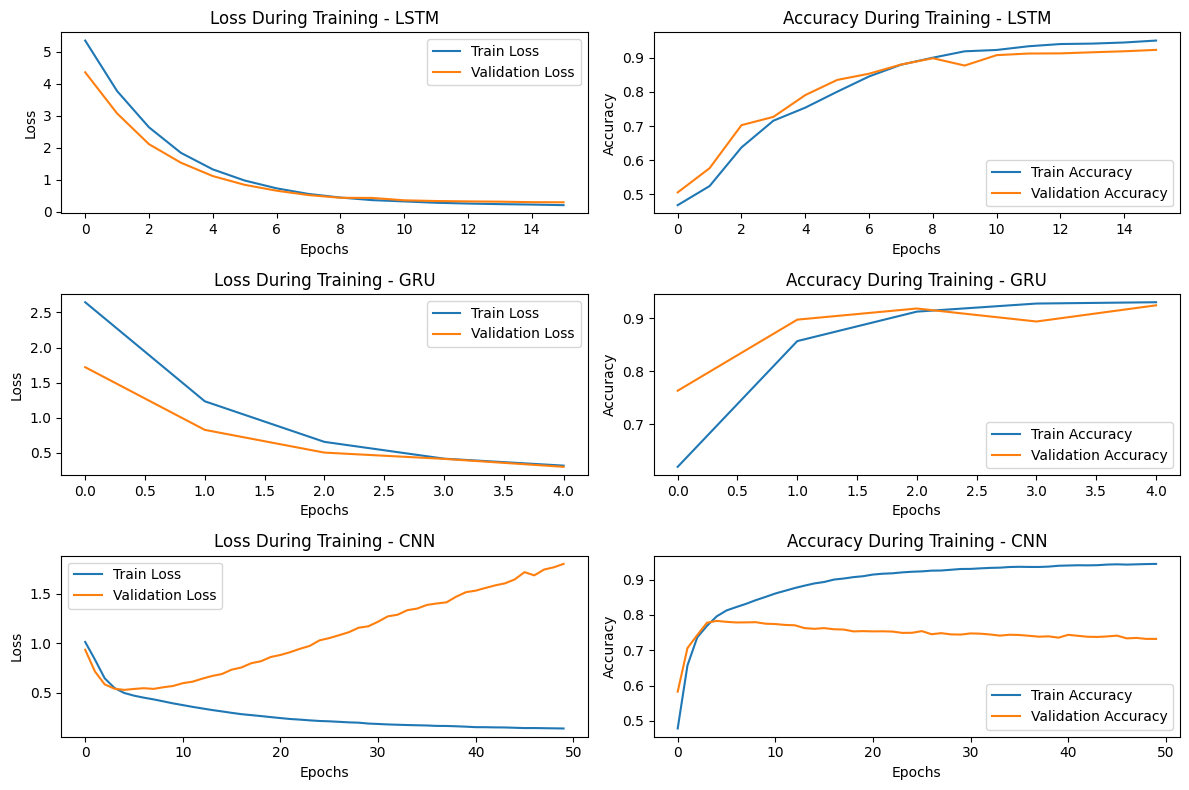

In [45]:
# Visualisasi Loss dan Accuracy untuk Ketiga Model
models = ['LSTM', 'GRU', 'CNN']
histories = [history_LSTM, history_GRU, history_CNN]

plt.figure(figsize=(12, 8))

for i, (model, history) in enumerate(zip(models, histories)):
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss During Training - {model}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy During Training - {model}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

## Testing

In [52]:
# Contoh sentiment ulasan baru
new_texts = [
    "Saya sangat puas dengan layanan Gopay, transaksi cepat dan tampilannya user-friendly, membantu aktivitas pembayaran sehari-hari.",
    "Aplikasi Gopay ga guna jelek banget bjir sangatt mengecewakann, sering terjadi delay saat proses pembayaran dan layanan pelanggan belum maksimal.",
    "Pengalaman menggunakan Gopay cukup membantu, saran buat kedepannya tambah fitur pesan suara hadiah THR."
]

# Nilai asli dari teks
true_labels = ["positive", "negative", "neutral"]

# Tokenisasi teks baru
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = pad_sequences(new_sequences, maxlen=X.shape[1])

# Membuat prediksi
predictions_LSTM = model_LSTM.predict(new_padded_sequences)
predictions_CNN = model_CNN.predict(new_padded_sequences)
predictions_GRU = GRU_model.predict(new_padded_sequences)

# Mengubah prediksi menjadi label
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)

predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)

# Menampilkan hasil prediksi
for text, true_label, label_LSTM, label_CNN, label_GRU in zip(new_texts, true_labels, predicted_labels_LSTM, predicted_labels_CNN, predicted_labels_GRU):
    print(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label (LSTM): {label_LSTM}\nPredicted Label (CNN): {label_CNN}\nPredicted Label (GRU): {label_GRU}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Text: Saya sangat puas dengan layanan Gopay, transaksi cepat dan tampilannya user-friendly, membantu aktivitas pembayaran sehari-hari.
True Label: positive
Predicted Label (LSTM): positive
Predicted Label (CNN): positive
Predicted Label (GRU): positive

Text: Aplikasi Gopay ga guna jelek banget bjir sangatt mengecewakann, sering terjadi delay saat proses pembayaran dan layanan pelanggan belum maksimal.
True Label: negative
Predicted Label (LSTM): negative
Predicted Label (CNN): negative
Predicted Label (GRU): negative

Text: Pengalaman menggunakan Gopay cukup membantu, saran buat kedepannya tambah fitur pesan suara hadiah THR.
True Label: neutral
Predicted Label (LSTM): neutral
Predicted Label (CNN): positive
Predicted Label (GRU): negative

